# Bank Marketing Dataset - Fairness Analysis

This notebook evaluates fairness vs information retention trade-offs on the UCI Bank Marketing dataset.

**Dataset**: Bank Marketing (~45,000 samples)

**Sensitive Attribute**: Age (Young <35 vs Old >=35)

**Task**: Predict term deposit subscription

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from datasets import load_bank_marketing, get_dataset_summary
from fairness_metrics import compute_all_fairness_metrics, compute_performance_metrics
from preprocessing import Reweighing, FeatureMasking, DisparateImpactRemover, LabelFlipping, SamplingStrategy
from inprocessing import FairnessRegularizedClassifier, AdversarialDebiasing, ConstrainedClassifier
from postprocessing import EqualizedOddsPostProcessor, ThresholdOptimizer, CalibratedPostProcessor, RejectOptionClassifier
from visualization import plot_accuracy_fairness_tradeoff, plot_grouped_bar_chart, plot_pareto_frontier, create_summary_dashboard

print("Modules loaded!")

Modules loaded!


## 1. Data Loading & Exploration

In [2]:
data = load_bank_marketing(sensitive_attr='age', random_state=42)
summary = get_dataset_summary(data)
display(summary)

print(f"\nDataset: {data['metadata']['name']}")
print(f"Task: {data['metadata']['task']}")
print(f"Sensitive Attribute: {data['sensitive_attr']}")
print(f"Groups: {data['metadata']['sensitive_groups']}")

,Dataset,Task,N Train,N Test,N Features,Positive Rate (Train),Sensitive Attr,Group 0 Rate,Group 1 Rate,Group 0 Pos Rate,Group 1 Pos Rate,Disparate Impact
0,Bank Marketing,Term deposit subscription prediction,28831,12357,19,11.27%,age,35.98%,64.02%,13.02%,10.28%,1.267



Dataset: Bank Marketing
Task: Term deposit subscription prediction
Sensitive Attribute: age
Groups: {0: 'Young (<35)', 1: 'Old (>=35)'}


In [3]:
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
sens_train, sens_test = data['sensitive_train'], data['sensitive_test']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Training samples: 28831
Test samples: 12357
Features: 19


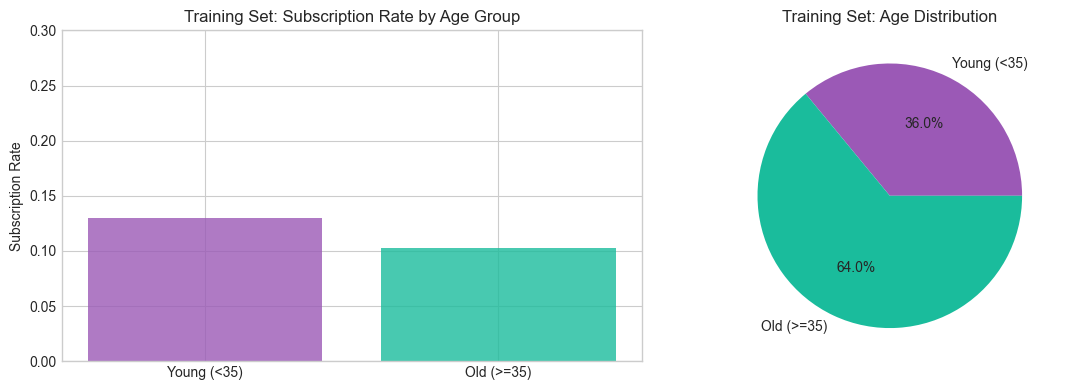

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for g, label in data['metadata']['sensitive_groups'].items():
    mask = sens_train == g
    pos_rate = y_train[mask].mean()
    ax.bar(label, pos_rate, color=['#9B59B6', '#1ABC9C'][g], alpha=0.8)
ax.set_ylabel('Subscription Rate')
ax.set_title('Training Set: Subscription Rate by Age Group')
ax.set_ylim(0, 0.3)

ax = axes[1]
sizes = [np.sum(sens_train == g) for g in data['metadata']['sensitive_groups'].keys()]
labels = list(data['metadata']['sensitive_groups'].values())
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#9B59B6', '#1ABC9C'])
ax.set_title('Training Set: Age Distribution')

plt.tight_layout()
plt.show()

## 2. Baseline Model

In [5]:
results = []

def evaluate_model(y_true, y_pred, y_prob, sensitive, method_name, category):
    perf = compute_performance_metrics(y_true, y_pred, y_prob)
    fair = compute_all_fairness_metrics(y_true, y_pred, y_prob, sensitive)
    return {
        'Method': method_name, 'Category': category,
        'Accuracy': perf['accuracy'], 'AUC': perf.get('auc', np.nan),
        'Precision': perf['precision'], 'Recall': perf['recall'], 'F1': perf['f1'],
        'DPD': fair['demographic_parity_difference'],
        'DPR': fair['demographic_parity_ratio'],
        'EOD': fair['equalized_odds_difference']['average'],
        'TPR_Diff': fair['equalized_odds_difference']['tpr_difference'],
        'FPR_Diff': fair['equalized_odds_difference']['fpr_difference']
    }

In [6]:
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)

y_pred_baseline = baseline_clf.predict(X_test)
y_prob_baseline = baseline_clf.predict_proba(X_test)[:, 1]

baseline_results = evaluate_model(y_test, y_pred_baseline, y_prob_baseline, sens_test, 'Baseline', 'Baseline')
results.append(baseline_results)

print(f"Baseline - Acc: {baseline_results['Accuracy']:.4f}, DPD: {baseline_results['DPD']:.4f}")

Baseline - Acc: 0.9013, DPD: 0.0016


## 3. Pre-processing Methods

In [7]:
# Reweighing
reweigher = Reweighing()
reweigher.fit(X_train, y_train, sens_train)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train, sample_weight=reweigher.get_weights())
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, 'Reweighing', 'Pre-processing'))
print(f"Reweighing: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# DIR
for rl in [0.5, 1.0]:
    dir_proc = DisparateImpactRemover(sensitive_attr_idx=0, repair_level=rl)
    dir_proc.fit(X_train, sensitive=sens_train)
    X_tr = dir_proc.transform(X_train, sens_train)
    X_te = dir_proc.transform(X_test, sens_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'DIR (r={rl})', 'Pre-processing'))
    print(f"DIR (r={rl}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Label Flipping
for strategy in ['targeted', 'equalize']:
    flipper = LabelFlipping(flip_rate=0.1, strategy=strategy)
    flipper.fit(X_train, y_train, sens_train)
    y_flipped = flipper.transform(y_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_flipped)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'LabelFlip ({strategy})', 'Pre-processing'))
    print(f"LabelFlip ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Sampling
for strategy in ['oversample', 'undersample', 'hybrid']:
    sampler = SamplingStrategy(strategy=strategy)
    X_res, y_res, s_res = sampler.fit_resample(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Sampling ({strategy})', 'Pre-processing'))
    print(f"Sampling ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Reweighing: Acc=0.9004, DPD=0.0058
DIR (r=0.5): Acc=0.9005, DPD=0.0008
DIR (r=1.0): Acc=0.9006, DPD=0.0025
LabelFlip (targeted): Acc=0.8952, DPD=0.0485
LabelFlip (equalize): Acc=0.9003, DPD=0.0071
Sampling (oversample): Acc=0.8127, DPD=0.0195
Sampling (undersample): Acc=0.8101, DPD=0.0208
Sampling (hybrid): Acc=0.8207, DPD=0.0190


## 4. In-processing Methods

In [8]:
# Fairness Regularized
for lf in [0.1, 0.5, 1.0, 2.0]:
    clf = FairnessRegularizedClassifier(lambda_fairness=lf, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'FairReg (λ={lf})', 'In-processing'))
    print(f"FairReg (λ={lf}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Adversarial Debiasing  
for aw in [0.5, 1.0]:
    try:
        clf = AdversarialDebiasing(adversary_weight=aw, n_epochs=30, use_pytorch=True)
        clf.fit(X_train, y_train, sens_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Adversarial (w={aw})', 'In-processing'))
        print(f"Adversarial (w={aw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")
    except Exception as e:
        print(f"Adversarial failed: {e}")

# Constrained
for th in [0.05, 0.1]:
    clf = ConstrainedClassifier(constraint_threshold=th, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Constrained (ε={th})', 'In-processing'))
    print(f"Constrained (ε={th}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

FairReg (λ=0.1): Acc=0.8874, DPD=0.0000
FairReg (λ=0.5): Acc=0.8874, DPD=0.0000
FairReg (λ=1.0): Acc=0.8874, DPD=0.0000
FairReg (λ=2.0): Acc=0.8874, DPD=0.0001
Adversarial (w=0.5): Acc=0.9014, DPD=0.0016
Adversarial (w=1.0): Acc=0.9008, DPD=0.0087
Constrained (ε=0.05): Acc=0.8983, DPD=0.0026
Constrained (ε=0.1): Acc=0.8983, DPD=0.0026


## 5. Post-processing Methods

In [9]:
y_prob_train = baseline_clf.predict_proba(X_train)[:, 1]

# Equalized Odds
eo = EqualizedOddsPostProcessor(objective='equalized_odds')
eo.fit(y_train, y_prob_train, sens_train)
y_pred = eo.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, 'Equalized Odds', 'Post-processing'))
print(f"Equalized Odds: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Threshold Optimizer
for fw in [0.3, 0.5, 0.7]:
    to = ThresholdOptimizer(fairness_weight=fw)
    to.fit(y_train, y_prob_train, sens_train)
    y_pred = to.transform(y_prob_baseline, sens_test)
    results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, f'ThreshOpt (w={fw})', 'Post-processing'))
    print(f"ThreshOpt (w={fw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Calibrated
cal = CalibratedPostProcessor(n_bins=10)
cal.fit(y_train, y_prob_train, sens_train)
y_prob_cal = cal.transform(y_prob_baseline, sens_test)
y_pred = (y_prob_cal >= 0.5).astype(int)
results.append(evaluate_model(y_test, y_pred, y_prob_cal, sens_test, 'Calibrated', 'Post-processing'))
print(f"Calibrated: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# Reject Option
priv_group = 1 if y_train[sens_train == 1].mean() > y_train[sens_train == 0].mean() else 0
ro = RejectOptionClassifier(privileged_group=priv_group)
ro.fit(y_train, y_prob_train, sens_train)
y_pred = ro.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, 'Reject Option', 'Post-processing'))
print(f"Reject Option: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Equalized Odds: Acc=0.8610, DPD=0.0217
ThreshOpt (w=0.3): Acc=0.9013, DPD=0.0016
ThreshOpt (w=0.5): Acc=0.9013, DPD=0.0016
ThreshOpt (w=0.7): Acc=0.9013, DPD=0.0016
Calibrated: Acc=0.9013, DPD=0.0016
Reject Option: Acc=0.9005, DPD=0.0125


## 6. Results Summary

In [10]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,DPR,EOD,TPR_Diff,FPR_Diff
13,Adversarial (w=0.5),In-processing,0.901351,NaN,0.679834,0.234914,0.349172,0.001580,0.960443,0.038144,0.071667,0.004622
20,ThreshOpt (w=0.7),Post-processing,0.901271,NaN,0.709756,0.209052,0.322974,0.001641,0.952073,0.038925,0.072358,0.005491
0,Baseline,Baseline,0.901271,NaN,0.709756,0.209052,0.322974,0.001641,0.952073,0.038925,0.072358,0.005491
18,ThreshOpt (w=0.3),Post-processing,0.901271,NaN,0.709756,0.209052,0.322974,0.001641,0.952073,0.038925,0.072358,0.005491
21,Calibrated,Post-processing,0.901271,NaN,0.709756,0.209052,0.322974,0.001641,0.952073,0.038925,0.072358,0.005491
19,ThreshOpt (w=0.5),Post-processing,0.901271,NaN,0.709756,0.209052,0.322974,0.001641,0.952073,0.038925,0.072358,0.005491
14,Adversarial (w=1.0),In-processing,0.900785,NaN,0.655431,0.251437,0.363448,0.008727,0.821343,0.035984,0.061081,0.010887
3,DIR (r=1.0),Pre-processing,0.900623,NaN,0.701970,0.204741,0.317019,0.002496,0.927580,0.035332,0.065050,0.005614
2,DIR (r=0.5),Pre-processing,0.900542,NaN,0.698297,0.206178,0.318358,0.000808,0.976073,0.037423,0.070456,0.004390
22,Reject Option,Post-processing,0.900542,NaN,0.679121,0.221983,0.334597,0.012488,0.697247,0.063945,0.123976,0.003914


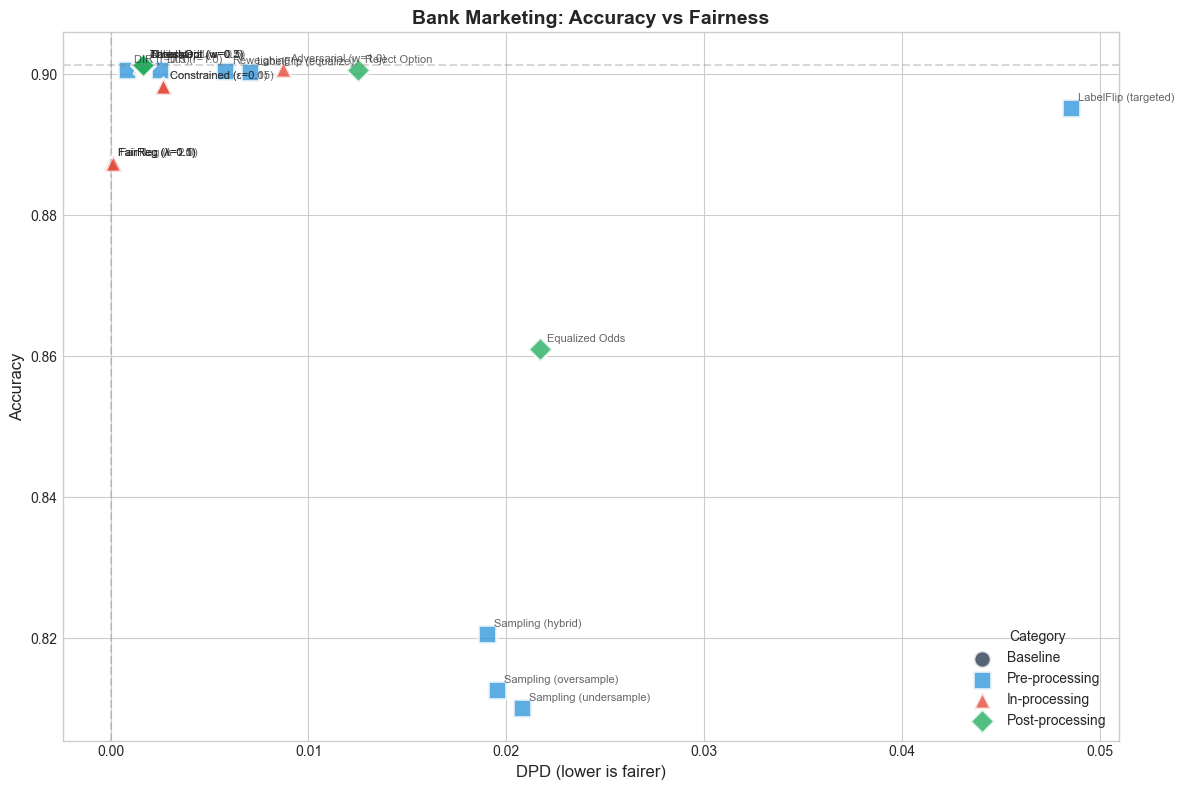

In [11]:
fig = plot_accuracy_fairness_tradeoff(results_df, title='Bank Marketing: Accuracy vs Fairness')
plt.show()

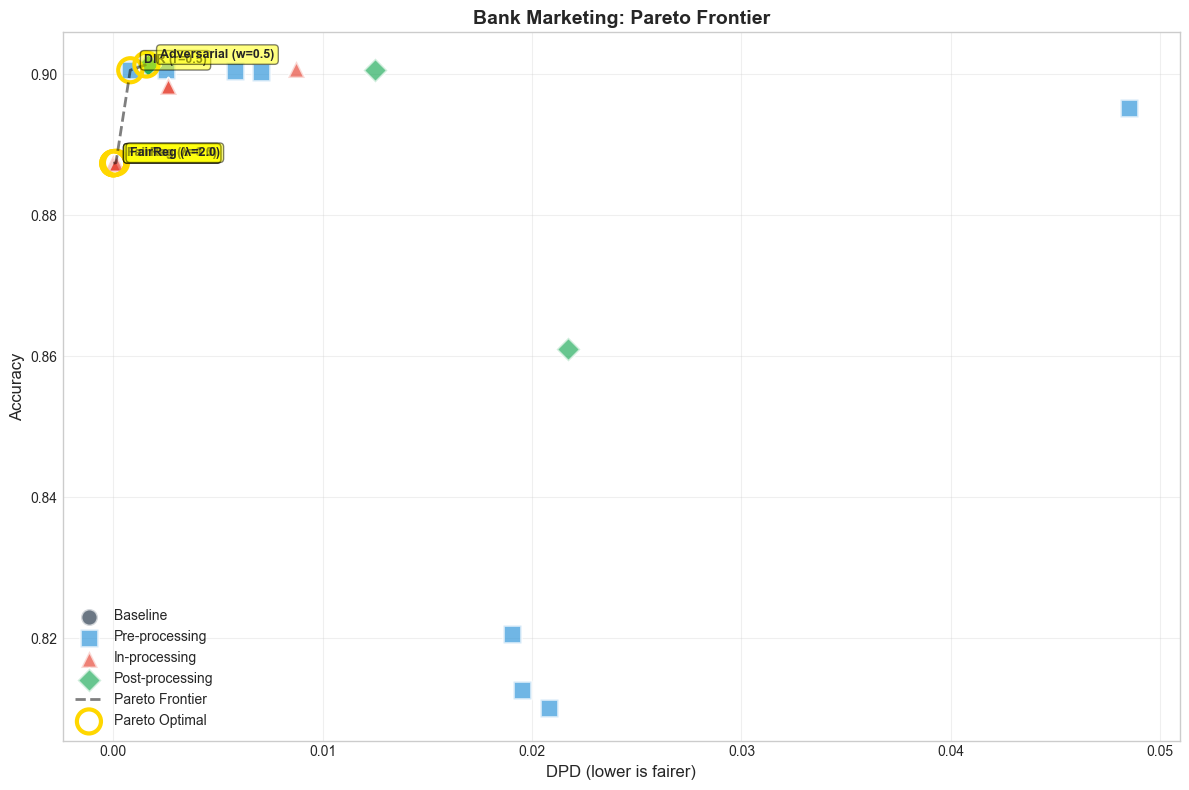

In [12]:
fig = plot_pareto_frontier(results_df, title='Bank Marketing: Pareto Frontier')
plt.show()

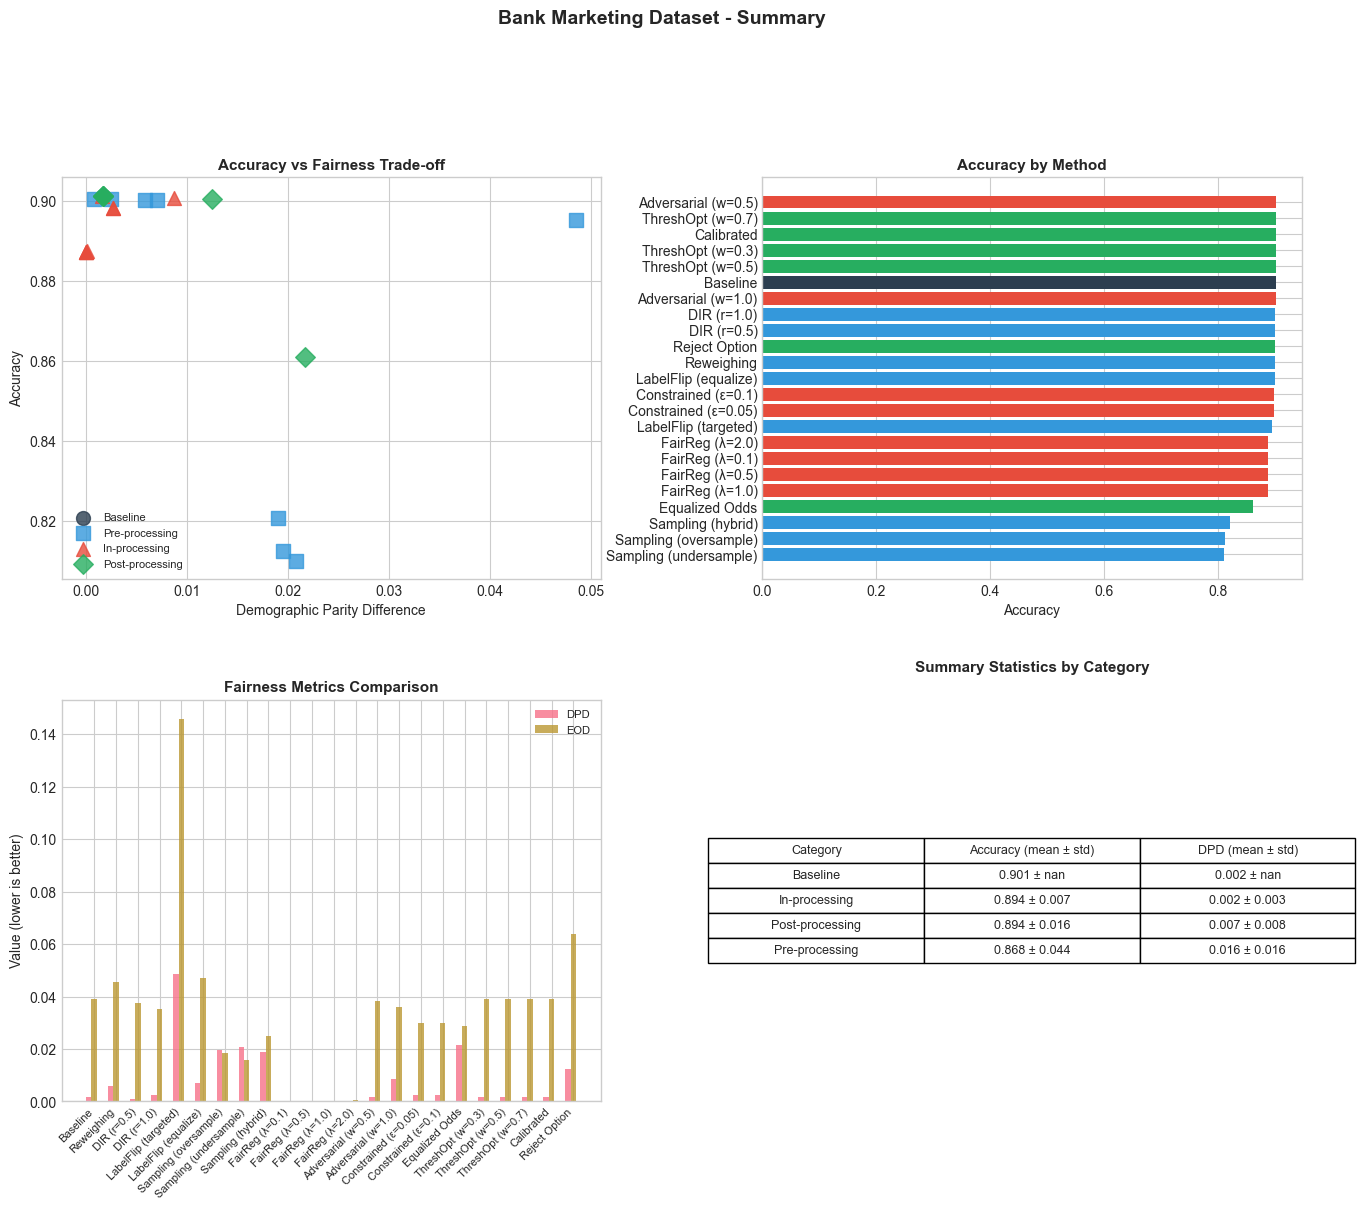

In [13]:
fig = create_summary_dashboard(results_df, title='Bank Marketing Dataset - Summary')
plt.show()

In [14]:
results_df.to_csv('../results/bank_marketing_results.csv', index=False)
print("Results saved!")

Results saved!
